In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric, get_roc_curve
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll import scope
import optuna
from optuna.samplers import TPESampler

import shap

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## EDA

In [7]:
df = pd.read_csv('../first_part/2. Cup_IT_2022_Датасет_Data_Science.csv')
df_2 = pd.read_csv('Cup_IT_2022_Data_Science_additional_data.csv')

df = pd.concat([df, df_2], axis=1)
df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)

In [8]:
df.head()

,client_id,is_in_club,cnt_checks_10_Мясная гастрономия,rto_std_11,rto_6,rto_12_Сыры,rto_12_Птица и изделия из птицы,rto_8,cnt_checks_9,rto_9_Мясная гастрономия,rto_10_Птица и изделия из птицы,cnt_checks_9_Рыба и рыбные изделия,rto_stddev_6_Рыба и рыбные изделия,rto_12_Мясная гастрономия,rto_stddev_8_Крупы и зерновые,rto_12,rto_6_Птица и изделия из птицы,rto_6_Рыба и рыбные изделия,cnt_checks_11,rto_stddev_7_Птица и изделия из птицы,rto_stddev_9_Сыры,cnt_checks_10_Овощи - Фрукты,cnt_checks_12_Птица и изделия из птицы,rto_6_Мясная гастрономия,rto_stddev_6_Овощи - Фрукты,cnt_checks_6_Мясная гастрономия,rto_stddev_6_Мясная гастрономия,cnt_checks_11_Сыры,cnt_checks_12_Овощи - Фрукты,rto_stddev_10_Птица и изделия из птицы,cnt_checks_6_Сыры,rto_stddev_10_Овощи - Фрукты,rto_12_Крупы и зерновые,rto_7_Птица и изделия из птицы,cnt_checks_12_Рыба и рыбные изделия,rto_stddev_10_Крупы и зерновые,rto_7_Крупы и зерновые,rto_7_Овощи - Фрукты,cnt_checks_10_Птица и изделия из птицы,rto_9_Рыба и рыбные изделия,cnt_checks_11_Крупы и зерновые,rto_stddev_11_Крупы и зерновые,rto_stddev_6_Крупы и зерновые,rto_stddev_12_Овощи - Фрукты,cnt_checks_11_Рыба и рыбные изделия,rto_stddev_9_Крупы и зерновые,rto_11_Крупы и зерновые,rto_stddev_10_Сыры,cnt_checks_12_Мясная гастрономия,rto_stddev_10_Мясная гастрономия,rto_stddev_8_Рыба и рыбные изделия,cnt_checks_9_Крупы и зерновые,rto_10_Сыры,rto_stddev_6_Сыры,cnt_checks_7_Сыры,cnt_checks_6_Птица и изделия из птицы,cnt_checks_6_Рыба и рыбные изделия,rto_8_Овощи - Фрукты,cnt_checks_10_Крупы и зерновые,rto_12_Овощи - Фрукты,rto_11_Мясная гастрономия,cnt_checks_12_Крупы и зерновые,rto_stddev_11_Мясная гастрономия,rto_stddev_12_Птица и изделия из птицы,rto_stddev_7_Крупы и зерновые,cnt_checks_6,cnt_checks_9_Овощи - Фрукты,cnt_checks_7_Крупы и зерновые,cnt_checks_8_Птица и изделия из птицы,rto_11_Птица и изделия из птицы,rto_stddev_11_Сыры,cnt_checks_7_Птица и изделия из птицы,rto_10_Овощи - Фрукты,rto_stddev_7_Мясная гастрономия,rto_9_Сыры,rto_10_Мясная гастрономия,rto_stddev_12_Рыба и рыбные изделия,cnt_checks_7,rto_7_Мясная гастрономия,cnt_checks_9_Мясная гастрономия,cnt_checks_7_Мясная гастрономия,rto_9_Овощи - Фрукты,rto_stddev_9_Птица и изделия из птицы,rto_std_9,rto_stddev_10_Рыба и рыбные изделия,rto_stddev_9_Рыба и рыбные изделия,cnt_checks_9_Сыры,rto_stddev_6_Птица и изделия из птицы,rto_10_Рыба и рыбные изделия,rto_12_Рыба и рыбные изделия,rto_10_Крупы и зерновые,cnt_checks_12,cnt_checks_10_Рыба и рыбные изделия,rto_stddev_9_Овощи - Фрукты,rto_11_Рыба и рыбные изделия,rto_6_Овощи - Фрукты,cnt_checks_10,rto_stddev_7_Овощи - Фрукты,cnt_checks_12_Сыры,rto_std_7,cnt_checks_8_Овощи - Фрукты,rto_stddev_8_Мясная гастрономия,rto_stddev_11_Овощи - Фрукты,cnt_checks_7_Овощи - Фрукты,rto_9_Птица и изделия из птицы,cnt_checks_6_Крупы и зерновые,cnt_checks_8_Крупы и зерновые,cnt_checks_7_Рыба и рыбные изделия,cnt_checks_11_Овощи - Фрукты,cnt_checks_8_Рыба и рыбные изделия,cnt_checks_11_Мясная гастрономия,rto_8_Мясная гастрономия,rto_10,rto_std_8,rto_stddev_11_Птица и изделия из птицы,rto_stddev_8_Птица и изделия из птицы,rto_stddev_12_Мясная гастрономия,rto_6_Сыры,rto_7,rto_std_6,cnt_checks_9_Птица и изделия из птицы,rto_stddev_11_Рыба и рыбные изделия,rto_9,rto_std_10,rto_stddev_8_Сыры,rto_8_Птица и изделия из птицы,rto_11_Овощи - Фрукты,cnt_checks_11_Птица и изделия из птицы,rto_7_Рыба и рыбные изделия,cnt_checks_6_Овощи - Фрукты,rto_9_Крупы и зерновые,rto_7_Сыры,rto_8_Крупы и зерновые,cnt_checks_8_Мясная гастрономия,rto_stddev_7_Сыры,rto_8_Сыры,rto_11,rto_std_12,cnt_checks_10_Сыры,rto_stddev_12_Сыры,rto_6_Крупы и зерновые,rto_stddev_7_Рыба и рыбные изделия,rto_stddev_8_Овощи - Фрукты,rto_8_Рыба и рыбные изделия,rto_11_Сыры,cnt_checks_8_Сыры,cnt_checks_8,rto_stddev_9_Мясная гастрономия,rto_stddev_12_Крупы и зерновые,cnt_unique_plu_6,cnt_unique_plu_7,cnt_unique_plu_8,cnt_unique_plu_9,cnt_unique_plu_10,cnt_unique_plu_11,cnt_unique_plu_12,cnt_unique_plu_10_Мясная гастрономия,cnt_unique_plu_10_Овощи - Фрукты,cnt_unique_pl

In [10]:
PT = PowerTransformer()

x = PT.fit_transform(df.drop(['client_id', 'is_in_club'], axis=1))
x = pd.DataFrame(data=x, columns=df.columns[2:])
x['is_in_club'] = df['is_in_club']

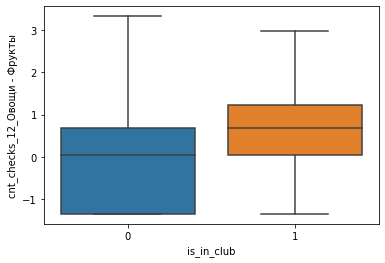

In [11]:
sns.boxplot(data=x, x="is_in_club", y='cnt_checks_12_Овощи - Фрукты', palette="tab10");

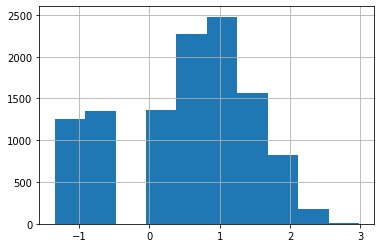

In [12]:
x[x.is_in_club==1]['cnt_checks_12_Овощи - Фрукты'].hist();

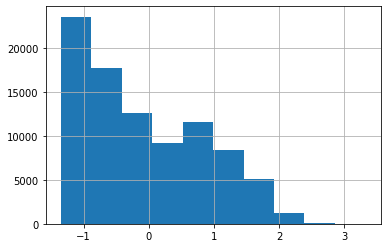

In [13]:
x[x.is_in_club==0]['cnt_checks_12_Овощи - Фрукты'].hist();

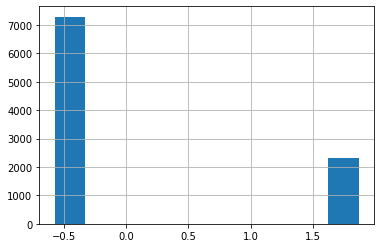

In [14]:
x[x.is_in_club==0]['cnt_checks_12_Рыба и рыбные изделия'].hist();

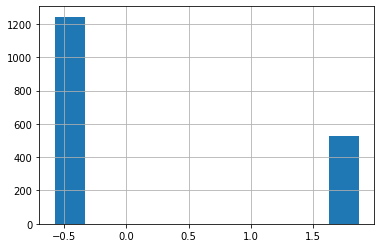

In [15]:
x[x.is_in_club==1]['cnt_checks_12_Рыба и рыбные изделия'].hist();

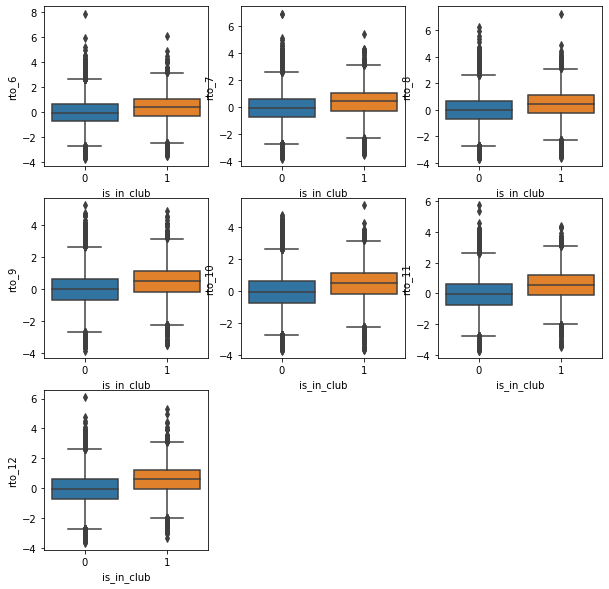

In [16]:
cotinuous_column_list = [ 'rto_6', 'rto_7', 'rto_8', 'rto_9',
                         'rto_10', 'rto_11', 'rto_12']
fig = plt.figure(figsize=(10,10))
# fig, ax = plt.subplots(3,3, figsize=(15,20))
row, col = 3, 3
for i in range(1,8):
    ax = fig.add_subplot(row, col, i)
    sns.boxplot(data=x, x="is_in_club", y=cotinuous_column_list[i-1], ax = ax, palette="tab10")
plt.show()

- Инфляция

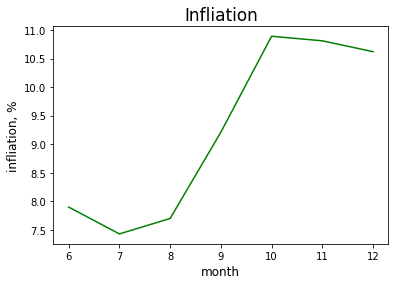

In [17]:
import re

infliation = {6: 7.9,
              7: 7.43,
              8: 7.7,
              9: 9.21,
              10: 10.89,
              11: 10.81,
              12: 10.62
              }

plt.plot(list(infliation.keys()), list(infliation.values()), color = 'green')
plt.xlabel('month', fontsize=12)
plt.ylabel('infliation, %', fontsize=12)
plt.title('Infliation', fontsize=17)

rto_columns = [ 'rto_6', 'rto_7', 'rto_8', 'rto_9',
                         'rto_10', 'rto_11', 'rto_12']
                         
for cat in (rto_columns):
    month = int(re.findall(r'\d+', cat)[0])
    inf_coef = 1+infliation[month]/100
    df[cat] = df[cat]*inf_coef

In [18]:
rto_columns = [ 'rto_6', 'rto_7', 'rto_8', 'rto_9',
                         'rto_10', 'rto_11', 'rto_12']
for cat in (rto_columns):
    month = int(re.findall(r'\d+', cat)[0])
    inf_coef = 1+infliation[month]/100
    df[cat+'_inf_diff'] = df[cat]*inf_coef - df[cat]

- quantile

In [19]:
categories = ['rto_6', 'rto_7', 'rto_8', 'rto_9', 'rto_10', 'rto_11', 'rto_12']       
for i, cat in enumerate(categories):
    df[f'cat_rto_{i}'] = (df[cat] > df[cat].quantile(0.8)).astype('int')
    
categories = ['rto_6_Овощи - Фрукты', 'rto_7_Овощи - Фрукты', 'rto_8_Овощи - Фрукты', 
              'rto_9_Овощи - Фрукты', 'rto_10_Овощи - Фрукты', 'rto_11_Овощи - Фрукты', 'rto_12_Овощи - Фрукты'] 
for i, cat in enumerate(categories):
    df[f'cat_fruit_rto_{i}'] = (df[cat] > df[cat].quantile(0.8)).astype('int')

- Рост зарплаты

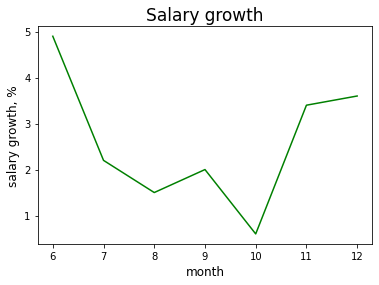

In [20]:
salary_growth = {
    6: 4.9,
    7: 2.2,
    8: 1.5,
    9: 2,
    10: 0.6,
    11: 3.4,
    12: 3.6
}

plt.plot(list(salary_growth.keys()), list(salary_growth.values()), color = 'green')
plt.xlabel('month', fontsize=12)
plt.ylabel('salary growth, %', fontsize=12)
plt.title('Salary growth', fontsize=17)

rto_columns = [ 'rto_6', 'rto_7', 'rto_8', 'rto_9',
                         'rto_10', 'rto_11', 'rto_12']
for cat in (rto_columns):
    month = int(re.findall(r'\d+', cat)[0])
    sal_coef = 1+salary_growth[month]/100
    df[cat+ '_sal_diff'] = df[cat]*sal_coef - df[cat]

## Data Preprocess

In [21]:
def data_preprocess(df):
    '''
    Fill nans with zeros, add features:
    cnt_rto_n_cat - сумма покупок клиента по всем категориям в разрезе месяца
    rto_n_category_part - доля данной категории от всех покупок в разрезе месяца
    '''
    df.fillna(0, inplace=True)

    for col in df.columns:
        if df[df[col] < 0].shape[0] > 0 and col.find('std') == -1:
            df.loc[df[col] < 0, col] = 0

    rto_n = df.columns[df.columns.str.contains(r"^rto_[0-9][0-9]*$")].sort_values(ascending = True)
    rto_n_category = df.columns[df.columns.str.contains(r"^rto_[0-9][0-9]*_[^0-9]+$")].sort_values(ascending = True)
    df[rto_n_category] = df[rto_n_category].fillna(0)

    for i in range(7):
        for rto_n_cat in rto_n_category[i*6:i*6+6]:
            df["cnt_rto_" + str(i) + "_cat" ] = (df[rto_n_category[0:6]]>0).sum(axis = 1)

    for i,r_n in enumerate(rto_n):
        for rto_n_cat in rto_n_category[i*6:i*6+6]:
            df[rto_n_cat + '_part'] = df[rto_n_cat]/df[r_n]

    for col in df.columns:
        if col.find('_part')!= -1:
            df.loc[df[col] == np.inf, col] = 0
    
    df = df.fillna(0)
    return df

In [22]:
df = data_preprocess(df)

In [23]:
sum(df.isna().sum() != 0), df.shape

(0, (135061, 275))

## Split data on train and test

In [24]:
TEST_SIZE = .3
RANDOM_STATE = 42
x = df.drop(['client_id', 'is_in_club'], axis=1)
y = df.is_in_club

X_train_val, X_test, y_train_val, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=TEST_SIZE, 
                                                            shuffle=True, 
                                                            stratify=y,
                                                            random_state=RANDOM_STATE)

## CatBoostClassifier 

 - Hyperparams opt (подбираем гиперпараметры на кросс валидации с искользованием библиотеки optuna)

In [25]:
N_SPLITS = 3
RANDOM_STATE = 42 
FOLD = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [26]:
def hyper_opt_loss(train_loss, val_loss, beta = 1.5):
    return -val_loss * np.exp(- beta * np.abs(val_loss - train_loss))

def opt_loss(train_loss, val_loss):
    return hyper_opt_loss(train_loss, val_loss)

In [27]:
def train_cb(params, 
             train_index, 
             val_index, 
             X_train_val,
             y_train_val):
    
    train_pool = Pool(X_train_val.iloc[train_index, :], label=y_train_val.iloc[train_index])
    val_pool = Pool(X_train_val.iloc[val_index, :], label=y_train_val.iloc[val_index])
    
    class_wei =  y_train_val.iloc[train_index].value_counts()[0] / y_train_val.iloc[train_index].value_counts()[1]
    model = CatBoostClassifier(**params, 
                               class_weights = (1, class_wei),
                               custom_metric='AUC:hints=skip_train~false',
                               eval_metric='AUC',
                               #task_type="GPU",
                               random_seed=42, 
                               early_stopping_rounds=20,
                               thread_count=16,
    )
    model.fit(train_pool, verbose=0, eval_set=val_pool)

    train_loss = model.best_score_['learn']['AUC']
    val_loss = model.best_score_['validation']['AUC']
    
    output = {
        'model': model,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    
    return output

In [28]:
def stat_score(params):
    train_losses, val_losses = [], []
    for train, validation in FOLD.split(X_train_val, y_train_val):
        result = train_cb(params, train, validation, X_train_val, y_train_val)    
        train_loss, val_loss = result['train_loss'], result['val_loss']
        train_losses += [train_loss]
        val_losses += [val_loss]
        
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    
    output = {
        'train': train_losses,
        'val': val_losses
    }
    return output

def score(params):
    stat = stat_score(params)
    
    train_loss = stat['train'].mean()
    val_loss = stat['val'].mean()
    
    return opt_loss(train_loss, val_loss)

In [29]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20), 
        'max_ctr_complexity':  trial.suggest_int('max_ctr_complexity', 0, 8), 
    } 

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    return score(param)

In [43]:
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=10) 
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-03-22 18:34:22,826] A new study created in memory with name: no-name-e4626435-775e-42ca-8d45-cd9338b00ac8
[I 2022-03-22 18:34:28,403] Trial 0 finished with value: -0.7015587779483291 and parameters: {'n_estimators': 452, 'learning_rate': 0.45886988140164003, 'l2_leaf_reg': 0.38026771974147267, 'colsample_bylevel': 0.05470951384808257, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 11, 'one_hot_max_size': 16, 'max_ctr_complexity': 5, 'bagging_temperature': 0.0330344331790966}. Best is trial 0 with value: -0.7015587779483291.
[I 2022-03-22 18:34:33,896] Trial 1 finished with value: -0.7075607972474863 and parameters: {'n_estimators': 430, 'learning_rate': 0.004323515841480409, 'l2_leaf_reg': 0.126766630509968, 'colsample_bylevel': 0.019611151935028673, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 11, 'max_ctr_complexity': 5}. Best is trial 1 with value: -0.7075607972474863.
[I 2

Number of completed trials: 10
Best trial:
	Best Score: -0.7090247608101233
	Best Params: 
    n_estimators: 394
    learning_rate: 0.00229646867747707
    l2_leaf_reg: 0.027694654484639977
    colsample_bylevel: 0.03264359223551126
    depth: 2
    boosting_type: Plain
    bootstrap_type: MVS
    min_data_in_leaf: 16
    one_hot_max_size: 16
    max_ctr_complexity: 2


In [33]:
#best_params = trail.params
# best_params = {
#     'boosting_type': 'Ordered',
#     'bootstrap_type': 'Bernoulli',
#     'colsample_bylevel': 0.08512900052697547,
#     'depth': 4,
#     'l2_leaf_reg': 0.04335660768413505,
#     'learning_rate': 0.005965363852834718,
#     'max_ctr_complexity': 2,
#     'min_data_in_leaf': 16,
#     'n_estimators': 361,
#     'one_hot_max_size': 9,
#     'subsample': 0.9989517974264015
# } #optuna best
best_params = {
    'boosting_type': 'Ordered',
     'depth': 3,
     'l2_leaf_reg': 4.757519417940943,
     'learning_rate': 0.05561681993507123,
     'max_ctr_complexity': 6,
     'n_estimators': 306
}#hyperopt best 

- Train CatBoostClassifier

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=TEST_SIZE, 
                                                  shuffle=True, 
                                                  stratify=y_train_val,
                                                  random_state=RANDOM_STATE)

In [35]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val,y_val)

class_wei = y_train.value_counts()[0] / y_train.value_counts()[1]
model = CatBoostClassifier(
    **best_params,
    class_weights = (1, class_wei),
    custom_metric='F1',
    early_stopping_rounds=10,
    use_best_model=True,
)

In [36]:
model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
y_pred = model.predict(X_test)
y_pred_proba_test_cb = model.predict_proba(X_test)
y_pred_proba_val_cb = model.predict_proba(X_val)

- Evaluating Quality

In [38]:
qwe = {
    'threshold': [],
    'F1': [],
    'AUC': []
}

for thr in np.arange(0, 1, 0.01):
    qwe['threshold'].append(thr)
    qwe['F1'].append(f1_score(y_test, (y_pred_proba_test_cb[:,1] > thr).astype(int)))
    qwe['AUC'].append(roc_auc_score(y_test, (y_pred_proba_test_cb[:,1] > thr).astype(int)))

qwe = pd.DataFrame(qwe, columns=['threshold', 'F1', 'AUC'])
print(qwe.sort_values('AUC', ascending=False).head(5))
qwe.sort_values('F1', ascending=False).head(10)

    threshold        F1       AUC
51       0.51  0.287837  0.677859
50       0.50  0.283502  0.677120
47       0.47  0.272937  0.676333
49       0.49  0.279221  0.676217
52       0.52  0.290115  0.676053


,threshold,F1,AUC
61,0.61,0.300009,0.647045
59,0.59,0.298464,0.654257
60,0.60,0.298156,0.649552
62,0.62,0.297564,0.640989
58,0.58,0.296924,0.657110
63,0.63,0.296845,0.636360
57,0.57,0.295482,0.660173
56,0.56,0.293453,0.662458
55,0.55,0.293313,0.666505
54,0.54,0.292079,0.669462


In [39]:
confusion_matrix(y_test, y_pred)
# array([[28907,  8711],
#        [ 1242,  1659]])
# array([[26989, 10629],
#        [ 1104,  1797]]). lgb

array([[25776, 11018],
       [ 1290,  2435]])

In [40]:
test_pool = Pool(X_test, y_test)
curve_train = get_roc_curve(model, train_pool) 
curve_val = get_roc_curve(model, val_pool) 
curve_test = get_roc_curve(model, test_pool)

(fpr_train, tpr_train, thresholds_train) = curve_train
(fpr_val, tpr_val, thresholds_val) = curve_val
(fpr_test, tpr_test, thresholds_test) = curve_test

roc_auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
roc_auc_val = sklearn.metrics.auc(fpr_val, tpr_val)
roc_auc_test = sklearn.metrics.auc(fpr_test, tpr_test)

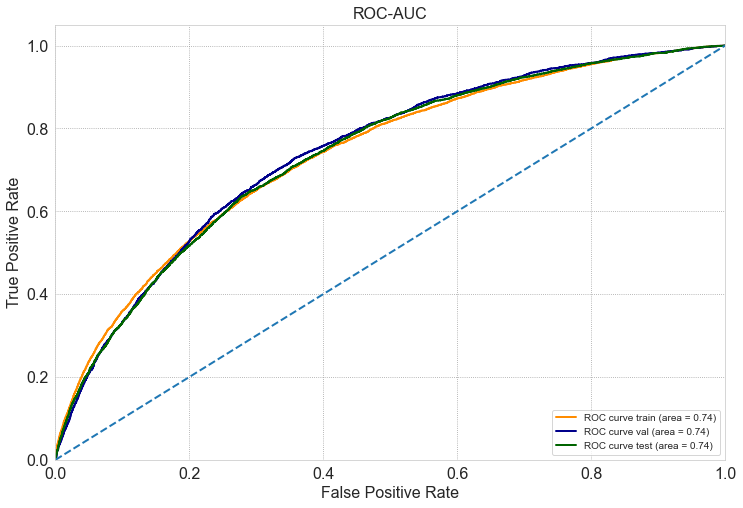

In [41]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.figure(figsize=(12, 8))
lw = 2
#roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='darkblue',
         lw=lw, label='ROC curve val (area = %0.2f)' % roc_auc_val)
plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate',size=16)
plt.ylabel('True Positive Rate', size=16)
plt.title('ROC-AUC', size=16)
plt.legend(loc="lower right")
plt.show()

## Feature importance

In [42]:
model.get_feature_importance(prettified=True)[:20]

,Feature Id,Importances
0,cnt_checks_12_Овощи - Фрукты,14.623158
1,cnt_unique_plu_12,8.912469
2,cnt_unique_plu_11,4.184685
3,cnt_checks_11_Овощи - Фрукты,3.338058
4,rto_stddev_10_Сыры,2.269363
5,cnt_unique_plu_11_Овощи - Фрукты,2.157602
6,cnt_checks_12_Птица и изделия из птицы,1.929615
7,cnt_checks_12,1.714084
8,rto_9_Мясная гастрономия,1.534002
9,cnt_unique_plu_7_Сыры,1.505712


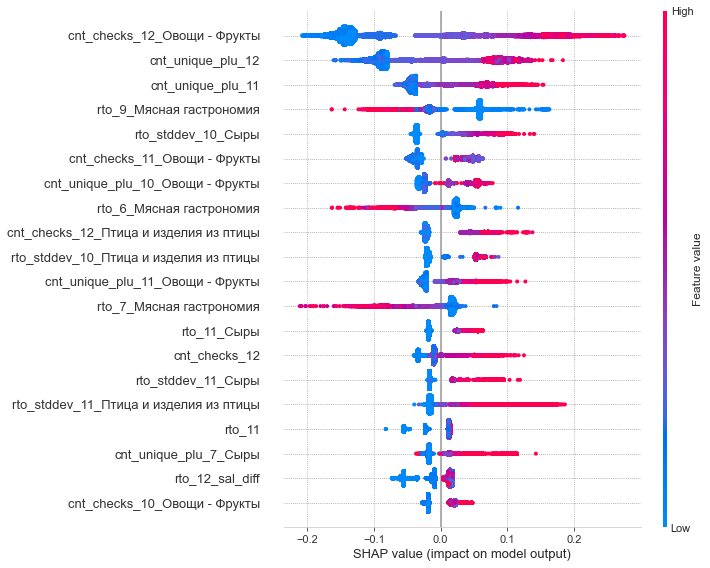

In [43]:
shap_values = model.get_feature_importance(train_pool, fstr_type='ShapValues')
shap.summary_plot(shap_values[:,:-1], X_train)

## LightGBM
- Hyperparam opt

In [47]:
RANDOM_STATE = 42
N_SPLITS = 3
EARLY_STOPPING_ROUNDS = 10
NUM_BOOST_ROUND = 2000
FOLD = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [48]:
best = {
    'bagging_fraction': 0.9,
     'feature_fraction': 0.1,
     'feature_fraction_bynode': 0.15000000000000002,
     'lambda_l1': 7.0,
     'lambda_l2': 13.0,
     'learning_rate': 0.025,
     'max_bin': 322,
     'metric': 'auc',
     'min_data_in_leaf': 3700,
     'neg_bagging_fraction': 0.6000000000000001,
     'nthread': 16,
     'num_leaves': 106,
     'objective': 'binary',
     'pos_bagging_fraction': 0.65
 }

In [49]:
train_data = lgb.Dataset(X_train.values, label=y_train)
val_data = lgb.Dataset(X_val.values, label=y_val)

model_lgb = lgb.train(best, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'val'],
                  num_boost_round=NUM_BOOST_ROUND, verbose_eval=False, early_stopping_rounds=EARLY_STOPPING_ROUNDS)

y_pred_proba_test_lgb = model_lgb.predict(X_test.values)
y_pred_proba_val_lgb = model_lgb.predict(X_val.values)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 6085, number of negative: 60094
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49828
[LightGBM] [Info] Number of data points in the train set: 66179, number of used features: 264
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091948 -> initscore=-2.290083
[LightGBM] [Info] Start training from score -2.290083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [50]:
qwe = {
    'threshold': [],
    'F1': [],
    'AUC': []
}

for thr in np.arange(0, 1, 0.01):
    qwe['threshold'].append(thr)
    qwe['F1'].append(f1_score(y_test, (y_pred_proba_test_lgb > thr).astype(int)))
    qwe['AUC'].append(roc_auc_score(y_test, (y_pred_proba_test_lgb > thr).astype(int)))

qwe = pd.DataFrame(qwe, columns=['threshold', 'F1', 'AUC'])
print(qwe.sort_values('AUC', ascending=False).head(5))
qwe.sort_values('F1', ascending=False).head(10)

    threshold        F1       AUC
9        0.09  0.260053  0.666291
10       0.10  0.276645  0.659932
8        0.08  0.232237  0.646528
11       0.11  0.286124  0.645501
12       0.12  0.280688  0.623025


,threshold,F1,AUC
11,0.11,0.286124,0.645501
12,0.12,0.280688,0.623025
10,0.10,0.276645,0.659932
13,0.13,0.266163,0.600576
9,0.09,0.260053,0.666291
14,0.14,0.237444,0.577271
8,0.08,0.232237,0.646528
7,0.07,0.198808,0.589707
15,0.15,0.190323,0.553283
1,0.01,0.168384,0.500000


In [52]:
thr = .11
confusion_matrix(y_test, (y_pred_proba_test_lgb > thr).astype(int))

array([[29761,  7033],
       [ 1929,  1796]])

In [296]:
print('Threshold .5, f1_score: ', f1_score(y_test, (y_pred_proba_test_lgb > .5).astype(int)))
print('THreshold .5, ROC-AUC: ', roc_auc_score(y_test, (y_pred_proba_test_lgb > .5).astype(int)))
print('Threshold {}, f1_score: {}'.format(thr, f1_score(y_test,
                                                      (y_pred_proba_test_lgb > thr).astype(int))))
print('THreshold {}, ROC-AUC: {}'.format(thr, 
                                         roc_auc_score(y_test, (y_pred_proba_test_lgb > thr).astype(int))))

Threshold .5, f1_score:  0.0010732492621411322
THreshold .5, ROC-AUC:  0.5002684563758389
Threshold 0.1, f1_score: 0.2879162254382869
THreshold 0.1, ROC-AUC: 0.6813399981686539


## Feature importance

## Merge CatBoost & LightGBM predictions

- Choose gamma & threshold on validation dataset

In [297]:
jkl = {
    'gamma': [],
    'threshold': [], 
    'F1_weighted': [], 
    'Precision_weighted': [], 
    'F1': [], 
    'Precision': [],
}
class_wei = int(y_val.value_counts()[0] / y_val.value_counts()[1])
d = {0: 1, 1: class_wei}

#y_test = pd.Series(y_test)
weights_for_val_set = y_val.copy()
weights_for_val_set = weights_for_val_set.map(d).values
#gamma = .5
for gamma in np.arange(0, 1.1, 0.1):
    for thr in np.arange(0, 1, 0.01):
      #model.set_probability_threshold(x)
        jkl['gamma'].append(gamma)
        jkl['threshold'].append(thr)
        y_pred = ((gamma*y_pred_proba_val_cb[:,1]  + (1-gamma)*y_pred_proba_val_lgb) > thr).astype(int)
        jkl['F1_weighted'].append(eval_metric(y_val.values, y_pred, 'F1', weight=weights_for_val_set)[0])
        jkl['F1'].append(eval_metric(y_val.values, y_pred, 'F1')[0])
        jkl['Precision_weighted'].append(eval_metric(y_val.values, y_pred, 'Precision', weight=weights_for_val_set)[0])
        jkl['Precision'].append(eval_metric(y_val.values, y_pred, 'Precision')[0])

jkl = pd.DataFrame(jkl)
print(jkl[jkl.threshold == .5])
jkl.sort_values('F1_weighted', ascending=False).head(15)

      gamma  threshold  F1_weighted  Precision_weighted        F1  Precision
50      0.0        0.5     0.000000            0.000000  0.000000   0.000000
150     0.1        0.5     0.005352            0.913043  0.005341   0.538462
250     0.2        0.5     0.018963            0.868726  0.018748   0.423729
350     0.3        0.5     0.059191            0.841121  0.056657   0.370370
450     0.4        0.5     0.141036            0.829436  0.126375   0.350785
550     0.5        0.5     0.259526            0.809779  0.208646   0.321116
650     0.6        0.5     0.397282            0.780217  0.274432   0.282865
750     0.7        0.5     0.510785            0.745706  0.301040   0.245754
850     0.8        0.5     0.592550            0.718405  0.307171   0.220860
950     0.9        0.5     0.640181            0.691111  0.298522   0.199104
1050    1.0        0.5     0.675514            0.671252  0.290751   0.184919


,gamma,threshold,F1_weighted,Precision_weighted,F1,Precision
1041,1.0,0.41,0.701952,0.617219,0.256064,0.151940
419,0.4,0.19,0.701571,0.598376,0.243301,0.142031
213,0.2,0.13,0.701227,0.605140,0.247763,0.145506
731,0.7,0.31,0.701225,0.618538,0.256875,0.152661
524,0.5,0.24,0.701161,0.617101,0.255877,0.151876
625,0.6,0.25,0.701139,0.594365,0.240609,0.140013
522,0.5,0.22,0.701028,0.595884,0.241593,0.140774
316,0.3,0.16,0.701012,0.601041,0.245001,0.143390
730,0.7,0.30,0.700973,0.609698,0.250802,0.147898
729,0.7,0.29,0.700871,0.601226,0.245106,0.143484


In [298]:
jkl = {
    'gamma': [],
    'threshold': [], 
    'F1_weighted': [], 
    'Precision_weighted': [], 
    'F1': [], 
    'Precision': [],
}
class_wei = int(y_test.value_counts()[0] / y_test.value_counts()[1])
d = {0: 1, 1: class_wei}

#y_test = pd.Series(y_test)
weights_for_test_set = y_test.copy()
weights_for_test_set = weights_for_test_set.map(d).values
#gamma = .5
for gamma in np.arange(0, 1.1, 0.1):
    for thr in np.arange(0, 1, 0.01):
        jkl['gamma'].append(gamma)
        jkl['threshold'].append(thr)
        y_pred = ((gamma*y_pred_proba_test_cb[:,1]  + (1-gamma)*y_pred_proba_test_lgb) > thr).astype(int)
        jkl['F1_weighted'].append(eval_metric(y_test.values, y_pred, 'F1', weight=weights_for_test_set)[0])
        jkl['F1'].append(eval_metric(y_test.values, y_pred, 'F1')[0])
        jkl['Precision_weighted'].append(eval_metric(y_test.values, y_pred, 'Precision', weight=weights_for_test_set)[0])
        jkl['Precision'].append(eval_metric(y_test.values, y_pred, 'Precision')[0])

jkl = pd.DataFrame(jkl)
print(jkl[jkl.threshold == .5])
jkl.sort_values('F1_weighted', ascending=False).head(50)

      gamma  threshold  F1_weighted  Precision_weighted        F1  Precision
50      0.0        0.5     0.001073            1.000000  0.001073   1.000000
150     0.1        0.5     0.003216            0.915254  0.003212   0.545455
250     0.2        0.5     0.016486            0.869159  0.016324   0.424658
350     0.3        0.5     0.062651            0.878935  0.060561   0.446494
450     0.4        0.5     0.157980            0.859923  0.143236   0.405507
550     0.5        0.5     0.284458            0.826043  0.229473   0.345386
650     0.6        0.5     0.404499            0.780240  0.277869   0.282893
750     0.7        0.5     0.511525            0.739921  0.297538   0.240185
850     0.8        0.5     0.589968            0.713120  0.302649   0.216422
950     0.9        0.5     0.637377            0.688545  0.296009   0.197198
1050    1.0        0.5     0.666905            0.666696  0.285780   0.181838


,gamma,threshold,F1_weighted,Precision_weighted,F1,Precision
315,0.3,0.15,0.696475,0.586262,0.234814,0.136027
212,0.2,0.12,0.696386,0.588159,0.236023,0.136949
418,0.4,0.18,0.696187,0.584857,0.233881,0.135348
521,0.5,0.21,0.695796,0.583810,0.233169,0.134844
625,0.6,0.25,0.695505,0.592359,0.238637,0.139014
728,0.7,0.28,0.695501,0.590637,0.237521,0.138164
831,0.8,0.31,0.695177,0.588999,0.236426,0.137360
624,0.6,0.24,0.695123,0.582495,0.232255,0.134214
1038,1.0,0.38,0.695074,0.593873,0.239570,0.139767
727,0.7,0.27,0.694952,0.581766,0.231773,0.133866


In [321]:
gamma, thr = 0.8, 0.35
y_pred = ((gamma*y_pred_proba_test_cb[:,1]  + (1-gamma)*y_pred_proba_test_lgb) > thr).astype(int)

In [322]:
confusion_matrix(y_test, y_pred)

array([[20551, 16243],
       [  804,  2921]])

In [334]:
pd.DataFrame(data={'client_id':X_test.index.values,
                   'score':(gamma*y_pred_proba_test_cb[:,1]  
                            + (1-gamma)*y_pred_proba_test_lgb)}).to_csv('fin_fin.csv', index=False)

## Power Transformer

In [192]:
PT = PowerTransformer()

x = PT.fit_transform(df.drop(['client_id', 'is_in_club'], axis=1))
x = pd.DataFrame(data=x, columns=df.columns[2:])
y = df.is_in_club

In [193]:
TEST_SIZE = .3
RANDOM_STATE = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=TEST_SIZE, 
                                                            shuffle=False, random_state=RANDOM_STATE)

In [195]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size=TEST_SIZE, 
                                                  shuffle=True, 
                                                  stratify=y_train_val,
                                                  random_state=RANDOM_STATE)

In [196]:
best_patams = {
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'colsample_bylevel': 0.08512900052697547,
    'depth': 4,
    'l2_leaf_reg': 0.04335660768413505,
    'learning_rate': 0.005965363852834718,
    'max_ctr_complexity': 2,
    'min_data_in_leaf': 16,
    'n_estimators': 361,
    'one_hot_max_size': 9,
    'subsample': 0.9989517974264015
}

In [197]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val,y_val)

class_wei = y_train.value_counts()[0] / y_train.value_counts()[1]
model = CatBoostClassifier(
    **best_params,
    class_weights = (1, class_wei),
    custom_metric='F1',
    early_stopping_rounds=10,
    use_best_model=True,
)

In [198]:
model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [199]:
y_pred_test_pt_cb = model.predict(X_test)
y_pred_proba_test_pt_cb = model.predict_proba(X_test)
y_pred_proba_val_pt_cb = model.predict_proba(X_val)

In [200]:
confusion_matrix(y_test, y_pred_test_pt_cb)

array([[28825,  8793],
       [ 1275,  1626]])

In [201]:
ANDOM_STATE = 42
TEST_SIZE = 0.25
N_SPLITS = 3
EVALS = 50# 
EARLY_STOPPING_ROUNDS = 10
NTHREAD = 16
NUM_BOOST_ROUND = 2000
FOLD = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [202]:
best = {
    'bagging_fraction': 0.9,
     'feature_fraction': 0.1,
     'feature_fraction_bynode': 0.15000000000000002,
     'lambda_l1': 7.0,
     'lambda_l2': 13.0,
     'learning_rate': 0.025,
     'max_bin': 322,
     'metric': 'auc',
     'min_data_in_leaf': 3700,
     'neg_bagging_fraction': 0.6000000000000001,
     'nthread': 16,
     'num_leaves': 106,
     'objective': 'binary',
     'pos_bagging_fraction': 0.65
 }

In [203]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model_lgb = lgb.train(best, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'val'],
                  num_boost_round=NUM_BOOST_ROUND, verbose_eval=False, early_stopping_rounds=EARLY_STOPPING_ROUNDS)

y_pred_proba_test_lgb = model_lgb.predict(X_test)
y_pred_proba_val_lgb = model_lgb.predict(X_val)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6662, number of negative: 59517
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44371
[LightGBM] [Info] Number of data points in the train set: 66179, number of used features: 189
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100666 -> initscore=-2.189842
[LightGBM] [Info] Start training from score -2.189842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [229]:
qwe = {
    'threshold': [],
    'F1': [],
    'AUC': []
}

for thr in np.arange(0, 1, 0.01):
    qwe['threshold'].append(thr)
    qwe['F1'].append(eval_metric(y_test.values, 
                                 (y_pred_proba_test_lgb > thr).astype(int),
                                'F1', weight=weights_for_test_set))
    qwe['AUC'].append(eval_metric(y_test.values,
                                    (y_pred_proba_test_lgb > thr).astype(int),
                                   'AUC'))

qwe = pd.DataFrame(qwe, columns=['threshold', 'F1', 'AUC'])
print(qwe.sort_values('AUC', ascending=False).head(5))
qwe.sort_values('F1', ascending=False).head(10)

    threshold                    F1                   AUC
8        0.08  [0.6728781975266814]  [0.6802456776753719]
9        0.09  [0.6560315787911614]   [0.678301337403495]
7        0.07  [0.6831088973322772]  [0.6762397743575455]
10       0.10  [0.6396179904187531]  [0.6758427792851263]
6        0.06  [0.6930640446452299]  [0.6696564224087682]


,threshold,F1,AUC
5,0.05,[0.6992470521380878],[0.6566857465115539]
4,0.04,[0.6953470265053899],[0.6274188095869453]
6,0.06,[0.6930640446452299],[0.6696564224087682]
7,0.07,[0.6831088973322772],[0.6762397743575455]
3,0.03,[0.679543830335484],[0.5757068659273307]
8,0.08,[0.6728781975266814],[0.6802456776753719]
9,0.09,[0.6560315787911614],[0.678301337403495]
2,0.02,[0.6526258462520774],[0.5082163291063126]
0,0.00,[0.6492232520840716],[0.5]
1,0.01,[0.6492232520840716],[0.5]


In [205]:
jkl = {
    'gamma': [],
    'threshold': [], 
    'F1_weighted': [], 
    'Precision_weighted': [], 
    'F1': [], 
    'Precision': [],
}
class_wei = int(y_test.value_counts()[0] / y_test.value_counts()[1])
d = {0: 1, 1: class_wei}

#y_test = pd.Series(y_test)
weights_for_test_set = y_test.copy()
weights_for_test_set = weights_for_test_set.map(d).values
#gamma = .5
for gamma in np.arange(0, 1.1, 0.1):
    for thr in np.arange(0, 1, 0.01):
        jkl['gamma'].append(gamma)
        jkl['threshold'].append(thr)
        y_pred = ((gamma*y_pred_proba_test_pt_cb[:,1]  + (1-gamma)*y_pred_proba_test_lgb) > thr).astype(int)
        jkl['F1_weighted'].append(eval_metric(y_test.values, y_pred, 'F1', weight=weights_for_test_set)[0])
        jkl['F1'].append(eval_metric(y_test.values, y_pred, 'F1')[0])
        jkl['Precision_weighted'].append(eval_metric(y_test.values, y_pred, 'Precision', weight=weights_for_test_set)[0])
        jkl['Precision'].append(eval_metric(y_test.values, y_pred, 'Precision')[0])

jkl = pd.DataFrame(jkl)
print(jkl[jkl.threshold == .5])
jkl.sort_values('F1_weighted', ascending=False).head(50)

      gamma  threshold  F1_weighted  Precision_weighted        F1  Precision
50      0.0        0.5     0.000689            0.923077  0.000689   0.500000
150     0.1        0.5     0.000689            0.750000  0.000688   0.200000
250     0.2        0.5     0.002753            0.774194  0.002741   0.222222
350     0.3        0.5     0.015712            0.862500  0.015499   0.343284
450     0.4        0.5     0.052787            0.857143  0.050351   0.333333
550     0.5        0.5     0.142741            0.850957  0.125486   0.322397
650     0.6        0.5     0.269236            0.813206  0.200901   0.266212
750     0.7        0.5     0.396987            0.778188  0.244698   0.226222
850     0.8        0.5     0.503221            0.747875  0.260324   0.198198
950     0.9        0.5     0.575587            0.717540  0.256250   0.174709
1050    1.0        0.5     0.618280            0.689348  0.244144   0.156061


,gamma,threshold,F1_weighted,Precision_weighted,F1,Precision
313,0.3,0.13,0.700497,0.573100,0.181012,0.100616
416,0.4,0.16,0.699824,0.574164,0.181551,0.101010
210,0.2,0.10,0.699464,0.570475,0.179509,0.099650
5,0.0,0.05,0.699247,0.594732,0.193126,0.108966
108,0.1,0.08,0.699235,0.592865,0.192045,0.108217
622,0.6,0.22,0.698518,0.575837,0.182385,0.101634
519,0.5,0.19,0.698506,0.574810,0.181818,0.101251
211,0.2,0.11,0.698369,0.590793,0.190788,0.107392
623,0.6,0.23,0.698146,0.588836,0.189652,0.106619
520,0.5,0.20,0.697968,0.588909,0.189680,0.106648


In [224]:
gamma, thr = 0.7, 0.32
y_pred = ((gamma*y_pred_proba_test_cb[:,1]  + (1-gamma)*y_pred_proba_test_lgb) > thr).astype(int)

In [225]:
confusion_matrix(y_test, y_pred)

array([[23968, 13650],
       [  827,  2074]])

In [ ]:
array([[23711, 13907],
       [  807,  2094]])